In [13]:
### 필요한 모듈 IMPORT
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [14]:
################################################
#####BASE MODEL 확인을 위한 간단한 전처리#########
################################################

# 파일 읽어오기
a=pd.read_csv(r"C:\Users\moonp\ASAC과정\ASAC_ml_project\web_crawling\merge_dataset\raw_merge.csv",sep="\t")
### METACRITIC 점수 표기 --> 메타크리틱 점수가 없는 경우 -1로 대체
a.metacritic=a.metacritic.fillna(-1)
tmp=a.dropna(axis=0)
### 동접자수 전처리 과정 동접자수 없는 경우 0으로 표기
tmp["24_Hour_Peak"].replace("Invalid","0",inplace=True)
tmp["All_time_peak"].replace("Invalid","0",inplace=True)
tmp["24_Hour_Peak"]=tmp["24_Hour_Peak"].astype(int)
tmp["All_time_peak"]=tmp["All_time_peak"].astype(int)

### is free 전처리 기존의 FALSE,TRUE --> 0,1로 바꾸어서
tmp.is_free.replace("False","0",inplace=True)
tmp.is_free.replace("0.0","0",inplace=True)
tmp.is_free.replace("True","1",inplace=True)
tmp.is_free.replace("1.0","1",inplace=True)
tmp.is_free=tmp.is_free.astype(int)
tmp.is_free=tmp.is_free.astype(int)


### TARGET CLASS를 4개로 재분류
No_interest_lst=['No user reviews','8 user reviews','7 user reviews','4 user reviews','9 user reviews','5 user reviews','6 user reviews','2 user reviews','3 user reviews','1 user reviews','None']
Positive_lst=['Overwhelmingly Positive','Very Positive','Positive','Mostly Positive']
Negative_lst=['Negative','Very Negative','Overwhelmingly Negative','Mostly Negative']
tmp.Review.replace(No_interest_lst,"Negative",inplace=True)
tmp.Review.replace(Positive_lst,"Positive",inplace=True)
tmp.Review.replace(Negative_lst,"Negative",inplace=True)
tmp.Review.replace("Mixed","Negative",inplace=True)

### TARGET LABEL ENCODING
le=preprocessing.LabelEncoder()
le.fit(np.array(tmp.Review))
y_true=le.fit_transform(tmp.Review)
print(le.classes_)

['Negative' 'Positive']


In [15]:
tmp_y=pd.DataFrame(y_true)

In [16]:
##########GENRE 없이 BASE MODEL 학습 RF로만 간단하게 구성 #########
# tmp=pd.concat([tmp,tmp_y],axis=1)
##########데이터 전처리 #######################################
x_no_genre=tmp.drop(columns=["appid","positive","negative","genre","new_date","Review","recommendations"])

In [17]:
pca_component=len(x_no_genre.columns)

In [18]:
pca_component

21

[0.94744739 0.03136192 0.0184831  0.00150039]


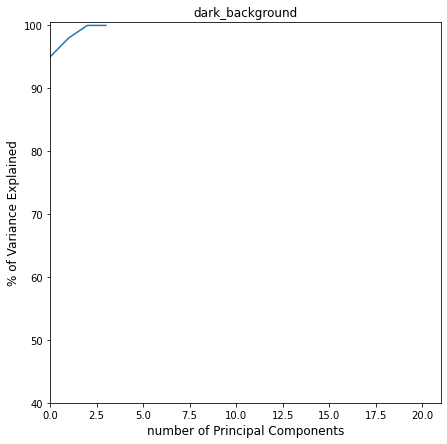

In [22]:
pca = PCA(n_components = pca_component)
pca.fit_transform(x_no_genre)


## percentage of variance explained
print(pca.explained_variance_ratio_)
# [0.92461872 0.05306648 0.01710261 0.00521218]
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=2)*100)
plt.title('dark_background')
## Principal 1 & 2 explain about 97.8% of variance
plt.rcParams['figure.figsize'] = (7, 7)
plt.plot(var)
plt.ylim(40,100.5)
plt.xlim(0,pca_component)
plt.xlabel("number of Principal Components", fontsize=12)
plt.ylabel("% of Variance Explained", fontsize=12)

plt.show()

In [ ]:
pca = PCA(n_components=4, random_state=1004)
x_pca = pca.fit_transform(x_no_genre)

In [ ]:
x_pca=pd.DataFrame(x_pca)

In [ ]:
x_pca.info()

In [ ]:
len(y_true)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_no_genre,    # 문제 --> train/val
    y_true,    # 정답지
    test_size= 0.2, # train 데이터 중에서 20프로만 중간 검사용으로 빼두자..
    random_state= 1234, # 옵션 : 나중에 재현성을 위해서 seed값.
    stratify = y_true # 옵션 : 나눌 때 비율을 유지할지 말지....
)


In [ ]:
kfold = KFold( n_splits=5, random_state=1234, shuffle=True)
# cv = 5 ---> 내가 run할 때 마다 셋들이 5개이기는 하지만 구성이 제각가..
# cv = kold ---> 언제, 어디서 하더라도 5개 셋이, 다 고정으로 동일하게 적용!!!
# 1) 모델
rf = RandomForestClassifier(n_jobs=-1, random_state=1234,verbose=2)
# 2) 파라미터의 조합 RGS --> 여러개가 있지만,,대표적인 것만 세팅..
parameters = {
    # 몇 개의 모델을 활용할지 
    "n_estimators" : [10, 100, 500, 1000], # 7
    # 세로에 대해서 어떻게 샘플링을 할지.
    "max_features" : ["sqrt","log2", None], # 3
    "min_samples_split" : [2, 5, 10],
    # 각 모델이 dt의 overfit을 조절하기
    "max_depth" : [2,5,10,20,100], # 10
    # min sample leaf
    "min_samples_leaf" : [1, 2, 4],
    "criterion" : ["gini", "entropy", "log_loss"],
    # 기타 여러 parameters 세팅 가능함....
}
# 3) RGS --> 몇 번 반복할지 
n_iter = 100
# 4) RGSCV 세팅.
rf_pca = RandomizedSearchCV( rf, 
                                  param_distributions= parameters,
                                  cv = kfold,
                                  scoring = "accuracy",
                                  n_jobs= -1,
                                  random_state=1234,
                                  n_iter = n_iter,verbose=3
                                  )
# 5) 학습
rf_pca.fit(x_train, y_train)

In [ ]:
rf_pca.best_score_
### pca-4 63.72%

In [6]:
df_genre=pd.DataFrame(tmp.genre)
##########Genre Category#########
genre_total_lst=dict()
for i in range(len(df_genre)):
    a=df_genre.iloc[i,0].replace(" ","").split(",")
    for j in range(len(a)):
        genre_total_lst[a[j]]=0
genre_total_lst=list(genre_total_lst.keys())

###########Genre Onehot##################################
df_genre=pd.DataFrame(tmp.genre)
genre_pre=[]
for i in range(len(df_genre)):
    a=df_genre.iloc[i,0].replace(" ","").split(",")
    category=[0 for j in range(len(genre_total_lst))]
    for j in range(len(a)):
        for k in range(len(genre_total_lst)):
            if a[j]==genre_total_lst[k]:
                category[k]+=1
    genre_pre.append(category)
genre_pre=pd.DataFrame(genre_pre)
genre_pre.columns=genre_total_lst

x_no_genre=tmp.drop(columns=["appid","positive","negative","genre","new_date","Review","recommendations"])
x_no_genre.reset_index(inplace=True)

onehot_x=pd.concat([x_no_genre,genre_pre],axis=1)
onehot_x=onehot_x.drop(columns=["index"])


In [7]:
tmp_y=pd.DataFrame(y_true)
pca_genre=pd.concat([onehot_x,tmp_y],axis=1)

In [9]:
onehot_x

,24_Hour_Peak,All_time_peak,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,num_lang,required_age,...,AudioProduction,PhotoEditing,GameDevelopment,ActionGames,Movie,Documentary,Episodic,Short,Tutorial,360V
0,20930,60742,12492,1401,5368,921,34.99,34.99,35,0.0,...,0,0,0,0,0,0,0,0,0,0
1,13428,53891,4018,277,1532,62,13.99,13.99,24,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1234,4148,1316,310,370,582,19.99,19.99,14,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4553,14880,1841,183,868,213,14.99,24.99,21,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4205,50876,1943,313,941,277,29.99,29.99,38,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46247,0,0,0,0,0,0,14.99,14.99,4,0.0,...,0,0,0,0,0,0,0,0,0,0
46248,0,0,0,0,0,0,9.99,9.99,1,0.0,...,0,0,0,0,0,0,0,0,0,0
46249,814,1176,0,0,0,0,0.00,0.00,0,0.0,...,0,0,0,0,0,0,0,0,0,0
46250,0,1,0,0,0,0,2.99,2.99,1,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pca = PCA(random_state=1004)
pca.fit_transform(genre_pre)


## percentage of variance explained
print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

# [0.92461872 0.05306648 0.01710261 0.00521218]


## Principal 1 & 2 explain about 97.8% of variance
plt.rcParams['figure.figsize'] = (7, 7)
plt.plot(range(1, genre_pre.shape[1]+1), pca.explained_variance_ratio_)
plt.xlabel("number of Principal Components", fontsize=12)
plt.ylabel("% of Variance Explained", fontsize=12)
plt.show()

In [ ]:
pca = PCA(n_components=4, random_state=1004)
genre_pca = pca.fit_transform(genre_pre)
genre_pca=pd.DataFrame(genre_pca)

In [ ]:
genre_pca.columns=["pca1","pca2","pca3","pca4"]

In [ ]:
x_genre_pca=pd.concat([x_no_genre,genre_pca],axis=1)
x_genre_pca=x_genre_pca.drop(columns=["index"])

In [ ]:
onehot_x.columns

In [10]:
x_train, x_val, y_train, y_val = train_test_split(
    onehot_x,    # 문제 --> train/val
    y_true,    # 정답지
    test_size= 0.2, # train 데이터 중에서 20프로만 중간 검사용으로 빼두자..
    random_state= 1234, # 옵션 : 나중에 재현성을 위해서 seed값.
    stratify = y_true # 옵션 : 나눌 때 비율을 유지할지 말지....
)
kfold = KFold( n_splits=5, random_state=1234, shuffle=True)
# cv = 5 ---> 내가 run할 때 마다 셋들이 5개이기는 하지만 구성이 제각가..
# cv = kold ---> 언제, 어디서 하더라도 5개 셋이, 다 고정으로 동일하게 적용!!!
# 1) 모델
rf = RandomForestClassifier(n_jobs=-1, random_state=1234,verbose=2)
# 2) 파라미터의 조합 RGS --> 여러개가 있지만,,대표적인 것만 세팅..
parameters = {
    # 몇 개의 모델을 활용할지 
    "n_estimators" : [10, 100, 500, 1000], # 7
    # 세로에 대해서 어떻게 샘플링을 할지.
    "max_features" : ["sqrt","log2", None], # 3
    "min_samples_split" : [2, 5, 10],
    # 각 모델이 dt의 overfit을 조절하기
    "max_depth" : [2,5,10,20,100], # 10
    # min sample leaf
    "min_samples_leaf" : [1, 2, 4],
    "criterion" : ["gini", "entropy", "log_loss"],
    # 기타 여러 parameters 세팅 가능함....
}
# 3) RGS --> 몇 번 반복할지 
n_iter = 100
# 4) RGSCV 세팅.
rf_onehot = RandomizedSearchCV( rf, 
                                  param_distributions= parameters,
                                  cv = kfold,
                                  scoring = "accuracy",
                                  n_jobs= -1,
                                  random_state=1234,
                                  n_iter = n_iter,verbose=3
                                  )
# 5) 학습
rf_onehot.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100building tree 11 of 100
building tree 12 of 100

building tree 13 of 100building tree 14 of 100
building tree 15 of 100

building tree 16 of 100
building tree 17 of 100
building tree 18 of 100building tree 19 of 100

building tree 20 of 100
building tree 21 of 100
building tree 22 of 100building tree 23 of 100

building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100building tree 39 of 100

building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100building tree 59 of 100

building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100building tree 67 of 100

building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100building tree 75 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    random_state=1234,
                                                    verbose=2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 5, 10, 20, 100],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 100, 500, 1000]},
                   random_state=1234, scoring='accuracy', verbose=3)

In [11]:
y_pred_val = rf_onehot.best_estimator_.predict(x_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [12]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      5367
           1       0.74      0.56      0.63      3884

    accuracy                           0.73      9251
   macro avg       0.73      0.71      0.71      9251
weighted avg       0.73      0.73      0.72      9251



In [ ]:
x_val

In [ ]:
y_pred_val = rf_onehot.best_estimator_.predict(x_val)

In [ ]:
print(classification_report(y_val, y_pred_val))

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_val, y_pred_val)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Mixed', 'Negative', 'No_interest', 'Positive']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
le.classes_

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

In [ ]:
x_smote

In [ ]:
kfold = KFold( n_splits=5, random_state=1234, shuffle=True)
# cv = 5 ---> 내가 run할 때 마다 셋들이 5개이기는 하지만 구성이 제각가..
# cv = kold ---> 언제, 어디서 하더라도 5개 셋이, 다 고정으로 동일하게 적용!!!
# 1) 모델
rf = RandomForestClassifier(n_jobs=-1, random_state=1234,verbose=2)
# 2) 파라미터의 조합 RGS --> 여러개가 있지만,,대표적인 것만 세팅..
parameters = {
    # 몇 개의 모델을 활용할지 
    "n_estimators" : [10, 100, 500, 1000], # 7
    # 세로에 대해서 어떻게 샘플링을 할지.
    "max_features" : ["sqrt","log2", None], # 3
    "min_samples_split" : [2, 5, 10],
    # 각 모델이 dt의 overfit을 조절하기
    "max_depth" : [2,5,10,20,100], # 10
    # min sample leaf
    "min_samples_leaf" : [1, 2, 4],
    "criterion" : ["gini", "entropy", "log_loss"],
    # 기타 여러 parameters 세팅 가능함....
}
# 3) RGS --> 몇 번 반복할지 
n_iter = 100
# 4) RGSCV 세팅.
rf_smote_base = RandomizedSearchCV( rf, 
                                  param_distributions= parameters,
                                  cv = kfold,
                                  scoring = "accuracy",
                                  n_jobs= -1,
                                  random_state=1234,
                                  n_iter = n_iter,verbose=3
                                  )
# 5) 학습
rf_smote_base.fit(x_smote, y_smote)

In [ ]:
y_pred_val = rf_smote_base.best_estimator_.predict(x_val)

In [ ]:
rf_parameter=[]
a_tmp=list(x_train.columns)
b_tmp=list(rf_smote_base.best_estimator_.feature_importances_)
for i in range(len(a_tmp)):
    rf_parameter.append([a_tmp[i],b_tmp[i]])
rf_parameter=pd.DataFrame(rf_parameter)
rf_parameter=rf_parameter.sort_values(by=[1],ascending=False)

In [ ]:
rf_parameter

In [ ]:
print(classification_report(y_val, y_pred_val))

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_val, y_pred_val)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Mixed', 'Negative', 'No_interest', 'Positive']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
df_genre=pd.DataFrame(tmp.genre)
##########Genre Category#########
genre_total_lst=dict()
for i in range(len(df_genre)):
    a=df_genre.iloc[i,0].replace(" ","").split(",")
    for j in range(len(a)):
        genre_total_lst[a[j]]=0
genre_total_lst=list(genre_total_lst.keys())

###########Genre Onehot##################################
df_genre=pd.DataFrame(tmp.genre)
genre_pre=[]
for i in range(len(df_genre)):
    a=df_genre.iloc[i,0].replace(" ","").split(",")
    category=[0 for j in range(len(genre_total_lst))]
    for j in range(len(a)):
        for k in range(len(genre_total_lst)):
            if a[j]==genre_total_lst[k]:
                category[k]+=1
    genre_pre.append(category)
genre_pre=pd.DataFrame(genre_pre)
genre_pre.columns=genre_total_lst

x_no_genre=tmp.drop(columns=["appid","positive","negative","genre","new_date","Review","recommendations"])
x_no_genre.reset_index(inplace=True)

onehot_x=pd.concat([x_no_genre,genre_pre],axis=1)
onehot_x=onehot_x.drop(columns=["index"])


In [ ]:
onehot_x

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    onehot_x,    # 문제 --> train/val
    y_true,    # 정답지
    test_size= 0.2, # train 데이터 중에서 20프로만 중간 검사용으로 빼두자..
    random_state= 1234, # 옵션 : 나중에 재현성을 위해서 seed값.
    stratify = y_true # 옵션 : 나눌 때 비율을 유지할지 말지....
)

In [ ]:
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

In [ ]:
kfold = KFold( n_splits=5, random_state=1234, shuffle=True)
# cv = 5 ---> 내가 run할 때 마다 셋들이 5개이기는 하지만 구성이 제각가..
# cv = kold ---> 언제, 어디서 하더라도 5개 셋이, 다 고정으로 동일하게 적용!!!
# 1) 모델
rf = RandomForestClassifier(n_jobs=-1, random_state=1234,verbose=2)
# 2) 파라미터의 조합 RGS --> 여러개가 있지만,,대표적인 것만 세팅..
parameters = {
    # 몇 개의 모델을 활용할지 
    "n_estimators" : [10, 100, 500, 1000], # 7
    # 세로에 대해서 어떻게 샘플링을 할지.
    "max_features" : ["sqrt","log2", None], # 3
    "min_samples_split" : [2, 5, 10],
    # 각 모델이 dt의 overfit을 조절하기
    "max_depth" : [2,5,10,20,100], # 10
    # min sample leaf
    "min_samples_leaf" : [1, 2, 4],
    "criterion" : ["gini", "entropy", "log_loss"],
    # 기타 여러 parameters 세팅 가능함....
}
# 3) RGS --> 몇 번 반복할지 
n_iter = 100
# 4) RGSCV 세팅.
rf_smote_onehot = RandomizedSearchCV( rf, 
                                  param_distributions= parameters,
                                  cv = kfold,
                                  scoring = "accuracy",
                                  n_jobs= -1,
                                  random_state=1234,
                                  n_iter = n_iter,verbose=3
                                  )
# 5) 학습
rf_smote_onehot.fit(x_smote, y_smote)

In [ ]:
rf_smote_onehot.best_score_

In [ ]:
y_pred_val = rf_smote_onehot.best_estimator_.predict(x_val)

In [ ]:
rf_smote_onehot.best_estimator_
# RandomForestClassifier(criterion='log_loss', max_depth=100, max_features=None,
#                        min_samples_split=10, n_estimators=1000, n_jobs=-1,
#                        random_state=1234, verbose=2)

In [ ]:
rf_parameter=[]
a_tmp=list(x_train.columns)
b_tmp=list(rf_smote_onehot.best_estimator_.feature_importances_)
for i in range(len(a_tmp)):
    rf_parameter.append([a_tmp[i],b_tmp[i]])
rf_parameter=pd.DataFrame(rf_parameter)
rf_parameter=rf_parameter.sort_values(by=[1],ascending=False)

In [ ]:
rf_parameter

In [ ]:
print(classification_report(y_val, y_pred_val))
#               precision    recall  f1-score   support

#            0       0.30      0.21      0.25      1315
#            1       0.12      0.14      0.13       232
#            2       0.66      0.78      0.71      3820
#            3       0.67      0.62      0.65      3884

#     accuracy                           0.62      9251
#    macro avg       0.44      0.44      0.43      9251
# weighted avg       0.60      0.62      0.60      9251

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_val, y_pred_val)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Mixed', 'Negative', 'No_interest', 'Positive']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

In [ ]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')

# fit predictor and target variable
x_tl, y_tl = tl.fit_resample(x_train, y_train)
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_tl))

In [ ]:
print('Original dataset shape', Counter(y_val))

In [ ]:
kfold = KFold( n_splits=5, random_state=1234, shuffle=True)
# cv = 5 ---> 내가 run할 때 마다 셋들이 5개이기는 하지만 구성이 제각가..
# cv = kold ---> 언제, 어디서 하더라도 5개 셋이, 다 고정으로 동일하게 적용!!!
# 1) 모델
rf = RandomForestClassifier(n_jobs=-1, random_state=1234,verbose=2)
# 2) 파라미터의 조합 RGS --> 여러개가 있지만,,대표적인 것만 세팅..
parameters = {
    # 몇 개의 모델을 활용할지 
    "n_estimators" : [10, 100, 500, 1000], # 7
    # 세로에 대해서 어떻게 샘플링을 할지.
    "max_features" : ["sqrt","log2", None], # 3
    "min_samples_split" : [2, 5, 10],
    # 각 모델이 dt의 overfit을 조절하기
    "max_depth" : [2,5,10,20,100], # 10
    # min sample leaf
    "min_samples_leaf" : [1, 2, 4],
    "criterion" : ["gini", "entropy", "log_loss"],
    # 기타 여러 parameters 세팅 가능함....
}
# 3) RGS --> 몇 번 반복할지 
n_iter = 100
# 4) RGSCV 세팅.
rf_tl_onehot = RandomizedSearchCV( rf, 
                                  param_distributions= parameters,
                                  cv = kfold,
                                  scoring = "accuracy",
                                  n_jobs= -1,
                                  random_state=1234,
                                  n_iter = n_iter,verbose=3
                                  )
# 5) 학습
rf_tl_onehot.fit(x_tl, y_tl)

In [ ]:
y_pred_val = rf_tl_onehot.best_estimator_.predict(x_val)

In [ ]:
rf_tl_onehot.best_score_
#66.6

In [ ]:
rf_parameter=[]
a_tmp=list(x_train.columns)
b_tmp=list(rf_tl_onehot.best_estimator_.feature_importances_)
for i in range(len(a_tmp)):
    rf_parameter.append([a_tmp[i],b_tmp[i]])
rf_parameter=pd.DataFrame(rf_parameter)
rf_parameter=rf_parameter.sort_values(by=[1],ascending=False)

In [ ]:
rf_parameter

In [ ]:
print(classification_report(y_val, y_pred_val))
#               precision    recall  f1-score   support

#            0       0.51      0.11      0.18      1315
#            1       0.57      0.03      0.07       232
#            2       0.61      0.92      0.74      3820
#            3       0.71      0.59      0.64      3884

#     accuracy                           0.64      9251
#    macro avg       0.60      0.41      0.40      9251
# weighted avg       0.64      0.64      0.60      9251

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_val, y_pred_val)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Mixed', 'Negative', 'No_interest', 'Positive']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(x_train, y_train)
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

In [ ]:
kfold = KFold( n_splits=5, random_state=1234, shuffle=True)
# cv = 5 ---> 내가 run할 때 마다 셋들이 5개이기는 하지만 구성이 제각가..
# cv = kold ---> 언제, 어디서 하더라도 5개 셋이, 다 고정으로 동일하게 적용!!!
# 1) 모델
rf = RandomForestClassifier(n_jobs=-1, random_state=1234,verbose=2)
# 2) 파라미터의 조합 RGS --> 여러개가 있지만,,대표적인 것만 세팅..
parameters = {
    # 몇 개의 모델을 활용할지 
    "n_estimators" : [10, 100, 500, 1000], # 7
    # 세로에 대해서 어떻게 샘플링을 할지.
    "max_features" : ["sqrt","log2", None], # 3
    "min_samples_split" : [2, 5, 10],
    # 각 모델이 dt의 overfit을 조절하기
    "max_depth" : [2,5,10,20,100], # 10
    # min sample leaf
    "min_samples_leaf" : [1, 2, 4],
    "criterion" : ["gini", "entropy", "log_loss"],
    # 기타 여러 parameters 세팅 가능함....
}
# 3) RGS --> 몇 번 반복할지 
n_iter = 1000
# 4) RGSCV 세팅.
rf_rus_onehot = RandomizedSearchCV( rf, 
                                  param_distributions= parameters,
                                  cv = kfold,
                                  scoring = "accuracy",
                                  n_jobs= -1,
                                  random_state=1234,
                                  n_iter = n_iter,verbose=3
                                  )
# 5) 학습
rf_rus_onehot.fit(x_rus, y_rus)

In [ ]:
y_pred_val = rf_rus_onehot.best_estimator_.predict(x_val)

In [ ]:
rf_rus_onehot.best_score_
#0.4860215053763442

In [ ]:
rf_parameter=[]
a_tmp=list(x_train.columns)
b_tmp=list(rf_rus_onehot.best_estimator_.feature_importances_)
for i in range(len(a_tmp)):
    rf_parameter.append([a_tmp[i],b_tmp[i]])
rf_parameter=pd.DataFrame(rf_parameter)
rf_parameter=rf_parameter.sort_values(by=[1],ascending=False)

In [ ]:
rf_parameter

In [ ]:
print(classification_report(y_val, y_pred_val))
#               precision    recall  f1-score   support

#            0       0.26      0.26      0.26      1315
#            1       0.07      0.42      0.12       232
#            2       0.66      0.71      0.69      3820
#            3       0.72      0.46      0.56      3884

#     accuracy                           0.53      9251
#    macro avg       0.43      0.46      0.41      9251
# weighted avg       0.62      0.53      0.56      9251

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_val, y_pred_val)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Mixed', 'Negative', 'No_interest', 'Positive']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
x_train.columns

In [ ]:

plt.rcParams['figure.figsize'] = (7, 7)
plt.scatter(x_train.dlc,x_train.num_lang,c=y_train)
plt.xlabel("dlc", fontsize=12)
plt.xlim(0,100)
plt.ylabel("achievements", fontsize=12)
plt.show()

In [ ]:
from costcla.models import CostSensitiveDecisionTreeClassifier,CostSensitiveRandomForestClassifier
from costcla.metrics import cost_loss, savings_score

In [ ]:
x_train

In [ ]:
cost_mat_train = np.zeros((len(y_train),4))
cost_mat_train[:,0]=5
#false negatives cost the transaction amount
cost_mat_train[:,1]=x_train["days_after_release"]
#true positives also cost 5
cost_mat_train[:,2]=5

cost_mat_test = np.zeros((len(y_val),4))
cost_mat_test[:,0]=5
cost_mat_test[:,1]=x_val["days_after_release"]
cost_mat_test[:,2]=5

In [ ]:
cost_mat_train

In [ ]:
g = CostSensitiveRandomForestClassifier()
g.fit(np.array(x_train), np.array(y_train), cost_mat_train)
y_pred_rf_cslr=g.predict(np.array(x_val))

In [ ]:
print('random forest: cost sensitve learning')
print(cost_loss(y_val,y_pred_rf_cslr,cost_mat_test))


In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_val,y_pred_rf_cslr)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Mixed', 'Negative', 'No_interest', 'Positive']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
additional=x_train["24_Hour_Peak"]/x_train["All_time_peak"]

In [ ]:
additional.fillna(0)

In [ ]:
x_train.info()

In [ ]:

plt.rcParams['figure.figsize'] = (7, 7)

plt.hist(x_train.dlc,bins=[i for i in range(10)],color=y_train)
plt.show()